In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1. Представление и предобработка текстовых данных

1.1 Операции по предобработке:
* токенизация
* стемминг / лемматизация
* удаление стоп-слов
* удаление пунктуации
* приведение к нижнему регистру
* любые другие операции над текстом

In [ ]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
text = 'Select your preferences and run the install command. Stable represents the most currently tested and supported version of PyTorch. Note that LibTorch is only available for C++'

Реализовать функцию `preprocess_text(text: str)`, которая:
* приводит строку к нижнему регистру
* заменяет все символы, кроме a-z, A-Z и знаков .,!? на пробел


In [ ]:
def preprocess_text(text):
   text = text.lower()
   tokens = word_tokenize(text)
   stop_words = set(stopwords.words('english'))
   tokens = [token for token in tokens if token.lower() not in stop_words]
   lemmatizer = WordNetLemmatizer()
   tokens = [lemmatizer.lemmatize(token) for token in tokens]

   text = ' '.join(tokens)
   text = re.sub(r'[^a-zA-Z.,!?]', ' ', text)
   text = text.replace(' .', '.')

   return text

In [ ]:
print(preprocess_text(text))

select preference run install command. stable represents currently tested supported version pytorch. note libtorch available c  


1.2 Представление текстовых данных при помощи бинарного кодирования


Представить первое предложение из `text` в виде тензора `sentence_t`: `sentence_t[i] == 1`, если __слово__ с индексом `i` присуствует в предложении.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def preprocess_and_vectorize_sentences(text):
    preprocessed_text = preprocess_text(text)
    sentences = nltk.sent_tokenize(preprocessed_text)

    vectorizer = CountVectorizer(binary=True)
    sentences_vec = vectorizer.fit_transform(sentences)

    df_binary = pd.DataFrame(sentences_vec.toarray(), columns=vectorizer.get_feature_names_out(), index=sentences)

    return df_binary

display(preprocess_and_vectorize_sentences(text))

,available,command,currently,install,libtorch,note,preference,pytorch,represents,run,select,stable,supported,tested,version
select preference run install command.,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0
stable represents currently tested supported version pytorch.,0,0,1,0,0,0,0,1,1,0,0,1,1,1,1
note libtorch available c,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0


## 2. Классификация фамилий по национальности

Датасет: https://disk.yandex.ru/d/owHew8hzPc7X9Q?w=1

2.1 Считать файл `surnames/surnames.csv`.

2.2 Закодировать национальности числами, начиная с 0.

2.3 Разбить датасет на обучающую и тестовую выборку

2.4 Реализовать класс `Vocab` (токен = __символ__)

2.5 Реализовать класс `SurnamesDataset`

2.6. Обучить классификатор.

2.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: прогнать несколько фамилий студентов группы через модели и проверить результат. Для каждой фамилии выводить 3 наиболее вероятных предсказания.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_surnames = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/surnames.csv')
display(df_surnames.head())

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


In [ ]:
df_surnames.describe()

,surname,nationality
count,10980,10980
unique,9041,18
top,Koury,English
freq,24,2972


In [ ]:
class Vocab:
    def __init__(self, data):
        self.idx_to_token, self.token_to_idx = self.build_vocab(data)
        self.vocab_len = len(self.idx_to_token)

    def build_vocab(self, data):
        tokens = set()
        for surname in data:
            tokens.update(surname) #добавляем именно символы фамилии

        idx_to_token = {idx: token for idx, token in enumerate(tokens)}
        token_to_idx = {token: idx for idx, token in enumerate(tokens)}

        return idx_to_token, token_to_idx

In [ ]:
from torch.utils.data import Dataset

class SurnamesDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, surname): #векторизация фамилии
      return [1 if str(char) in surname else 0 for char in self.vocab.token_to_idx]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx): #возвращается представление в виде словаря при вызове batch['surname'] и batch['target']
        surname = self.X.iloc[idx]
        nationality = self.y.iloc[idx]

        vectorized_surname = self.vectorize(surname)
        target = nationality

        return {'surname': torch.tensor(vectorized_surname, dtype=torch.float32), 'target':torch.tensor(target, dtype=torch.long)}

In [ ]:
nationality_to_idx = {nationality: idx for idx, nationality in enumerate(df_surnames['nationality'].unique())}
idx_to_nationality = {idx: nationality for idx, nationality in enumerate(df_surnames['nationality'].unique())}
df_surnames['nationality'] = df_surnames['nationality'].map(nationality_to_idx)

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_surnames, test_size=0.2, random_state=42)

vocab = Vocab(df_surnames['surname'])

train_dataset = SurnamesDataset(X=train_df['surname'], y=train_df['nationality'], vocab=vocab)
test_dataset = SurnamesDataset(X=test_df['surname'], y=test_df['nationality'], vocab=vocab)

In [ ]:
idx_to_nationality

{0: 'English',
 1: 'French',
 2: 'Arabic',
 3: 'Russian',
 4: 'Japanese',
 5: 'Chinese',
 6: 'Italian',
 7: 'Czech',
 8: 'Irish',
 9: 'German',
 10: 'Greek',
 11: 'Spanish',
 12: 'Polish',
 13: 'Dutch',
 14: 'Vietnamese',
 15: 'Korean',
 16: 'Portuguese',
 17: 'Scottish'}

In [ ]:
print(vocab.idx_to_token)
print(vocab.token_to_idx)

{0: 'T', 1: 'h', 2: 'ú', 3: 'A', 4: 'p', 5: 'L', 6: 'É', 7: 'f', 8: 'k', 9: 'ñ', 10: 'Ż', 11: 'o', 12: 'n', 13: 'E', 14: ':', 15: 'J', 16: '/', 17: 'í', 18: 'b', 19: 'ż', 20: 'ń', 21: 'Ś', 22: 'é', 23: 'O', 24: 'õ', 25: 'S', 26: 'e', 27: 'ü', 28: 'á', 29: 'r', 30: 'F', 31: 'q', 32: 'R', 33: "'", 34: 'ö', 35: 'ê', 36: 'ì', 37: 's', 38: 'x', 39: 'W', 40: 'm', 41: 'c', 42: 'Z', 43: 'à', 44: 'Y', 45: 't', 46: 'w', 47: 'ã', 48: 'D', 49: 'P', 50: 'z', 51: 'K', 52: 'Á', 53: 'ó', 54: 'Q', 55: 'g', 56: 'C', 57: 'u', 58: '-', 59: 'X', 60: 'N', 61: '1', 62: 'ò', 63: 'y', 64: 'U', 65: 'è', 66: 'ä', 67: 'ç', 68: 'H', 69: 'a', 70: 'j', 71: 'i', 72: 'V', 73: 'B', 74: 'l', 75: 'G', 76: 'd', 77: 'ł', 78: 'v', 79: 'ą', 80: 'M', 81: 'I', 82: 'ù', 83: 'ß'}
{'T': 0, 'h': 1, 'ú': 2, 'A': 3, 'p': 4, 'L': 5, 'É': 6, 'f': 7, 'k': 8, 'ñ': 9, 'Ż': 10, 'o': 11, 'n': 12, 'E': 13, ':': 14, 'J': 15, '/': 16, 'í': 17, 'b': 18, 'ż': 19, 'ń': 20, 'Ś': 21, 'é': 22, 'O': 23, 'õ': 24, 'S': 25, 'e': 26, 'ü': 27, 'á': 28, '

In [ ]:
train_dataset.X

8667        Murrell
292      Arrowsmith
10453        Haddad
9732      Marszałek
10337       Ramsden
            ...    
5734          Jacks
5191          Gerst
5390         Kassis
860        Altamura
7270        Coilean
Name: surname, Length: 8784, dtype: object

In [ ]:
train_dataset.y

8667      0
292       0
10453     2
9732     12
10337     0
         ..
5734      0
5191      9
5390      2
860       6
7270      8
Name: nationality, Length: 8784, dtype: int64

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class SurnameClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SurnameClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size * 3)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size * 3)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(hidden_size * 3, hidden_size * 3)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size * 3)
        self.relu2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(hidden_size * 3, hidden_size * 5)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size * 5)

        self.fc4 = nn.Linear(hidden_size * 5, output_size)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.batch_norm1(self.fc1(x))))
        x = self.dropout2(self.relu2(self.batch_norm2(self.fc2(x))))
        x = self.batch_norm3(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
def train(model, train_dl, optimizer, criterion):
    model.train()

    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0

    for batch in train_dl:
        inputs, targets = batch['surname'], batch['target']

        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss

        total_samples += targets.shape[0]

        _, prediction_indices = torch.max(outputs, 1)
        correct_samples += torch.sum(prediction_indices==targets)

    train_accuracy = float(correct_samples) / total_samples

    return total_loss, train_accuracy

In [ ]:
def test(model, test_dl):
    model.eval()

    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0
    predictions= []

    with torch.no_grad():
      for batch in test_dl:
          inputs, targets = batch['surname'], batch['target']

          outputs = model(inputs)
          loss = criterion(outputs, targets.squeeze())
          total_loss += loss


          total_samples += targets.shape[0]
          _, predictions_indices = torch.topk(outputs, 3, dim=1) # 3 наиболее вероятных класса
          predictions.append(predictions_indices.numpy())
          correct_samples += torch.sum(predictions_indices[:, 0]==targets)

    test_accuracy = correct_samples / total_samples

    return total_loss, test_accuracy, predictions

In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = vocab.vocab_len
output_size = len(nationality_to_idx)
hidden_size = 256
model = SurnameClassifier(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
param_num = sum(p.numel() for p in model.parameters())
print("Количество параметров:", param_num)

Количество параметров: 1668882


In [ ]:
losses_train, losses_test = [], []
for epoch in range(20):
    total_loss_train, train_accuracy = train(model, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy, predictions = test(model, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Loss: [140.3762], Train_acc: [0.4603], Loss: [27.6899], Test_acc: [0.5783]
epoch [2]: Loss: [106.3072], Train_acc: [0.5627], Loss: [23.8192], Test_acc: [0.6043]
epoch [3]: Loss: [95.6571], Train_acc: [0.5959], Loss: [22.6128], Test_acc: [0.6148]
epoch [4]: Loss: [88.3988], Train_acc: [0.6178], Loss: [22.1671], Test_acc: [0.6275]
epoch [5]: Loss: [84.0515], Train_acc: [0.6237], Loss: [21.6798], Test_acc: [0.6416]
epoch [6]: Loss: [80.7155], Train_acc: [0.6381], Loss: [20.7556], Test_acc: [0.6526]
epoch [7]: Loss: [77.9408], Train_acc: [0.6474], Loss: [20.1247], Test_acc: [0.6489]
epoch [8]: Loss: [75.6204], Train_acc: [0.6605], Loss: [19.9793], Test_acc: [0.6521]
epoch [9]: Loss: [74.5307], Train_acc: [0.6587], Loss: [19.7794], Test_acc: [0.6676]
epoch [10]: Loss: [72.6837], Train_acc: [0.6656], Loss: [19.9667], Test_acc: [0.6653]
epoch [11]: Loss: [72.3616], Train_acc: [0.6656], Loss: [19.9647], Test_acc: [0.6617]
epoch [12]: Loss: [69.2729], Train_acc: [0.6806], Loss: [19.8

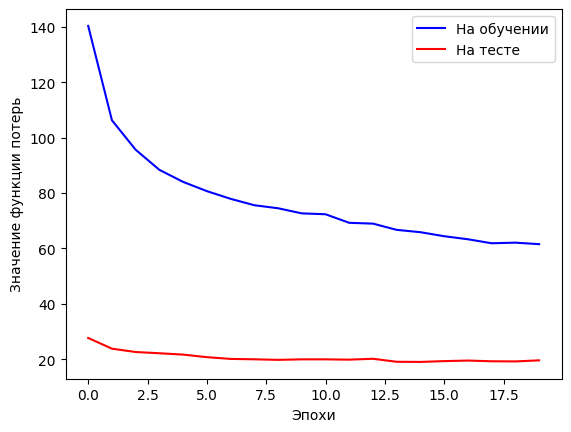

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses_train, label='На обучении', color='blue')
plt.plot(losses_test, label='На тесте', color='red')
plt.legend()
plt.xlabel('Эпохи')
plt.ylabel('Значение функции потерь')
plt.show()

In [ ]:
def vectorize_surname(surname): #векторизация фамилии
      return [1 if str(char) in surname else 0 for char in vocab.token_to_idx]

In [ ]:
import torch
import torch.nn.functional as F

input_surnames = ["Paramonov", "Trubina", "Donskova", "Martyshina"]

for input_surname in input_surnames:
    vec_input_surname = vectorize_surname(input_surname)
    input_tensor = torch.tensor(vec_input_surname, dtype=torch.float32).view(1, -1)

    with torch.no_grad():
        model.eval()
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted_labels = torch.topk(probabilities, len(idx_to_nationality), dim=1)

        predicted_countries = [idx_to_nationality[label.item()] for label in predicted_labels[0]]


        sorted_predictions = sorted(zip(predicted_countries, probabilities.flatten()), key=lambda x: x[1], reverse=True)

    print(f'{input_surname}:')
    for country, prob_percent in sorted_predictions:
        print(f'Страна: {country}, Вероятность: {prob_percent.item() * 100:.7f}%')
    print()

Paramonov:
Страна: Czech, Вероятность: 81.5010905%
Страна: Russian, Вероятность: 11.0369705%
Страна: Spanish, Вероятность: 5.5043276%
Страна: German, Вероятность: 1.4281532%
Страна: English, Вероятность: 0.2676195%
Страна: Greek, Вероятность: 0.1316662%
Страна: Japanese, Вероятность: 0.0907751%
Страна: Scottish, Вероятность: 0.0182252%
Страна: Dutch, Вероятность: 0.0065647%
Страна: Arabic, Вероятность: 0.0049253%
Страна: Polish, Вероятность: 0.0043328%
Страна: French, Вероятность: 0.0017495%
Страна: Korean, Вероятность: 0.0017228%
Страна: Portuguese, Вероятность: 0.0015128%
Страна: Vietnamese, Вероятность: 0.0002245%
Страна: Irish, Вероятность: 0.0001165%
Страна: Chinese, Вероятность: 0.0000245%
Страна: Italian, Вероятность: 0.0000002%

Trubina:
Страна: Italian, Вероятность: 52.3666859%
Страна: Spanish, Вероятность: 34.6546769%
Страна: Russian, Вероятность: 6.6034324%
Страна: French, Вероятность: 3.8002282%
Страна: Vietnamese, Вероятность: 0.8873512%
Страна: German, Вероятность: 0.4768

## 3. Классификация обзоров ресторанов

Датасет: https://disk.yandex.ru/d/nY1o70JtAuYa8g

3.1 Считать файл `yelp/raw_train.csv`. Оставить от исходного датасета 10% строчек.

3.2 Воспользоваться функцией `preprocess_text` из 1.1 для обработки текста отзыва. Закодировать рейтинг числами, начиная с 0.

3.3 Разбить датасет на обучающую и тестовую выборку

3.4 Реализовать класс `Vocab` (токен = слово)

3.5 Реализовать класс `ReviewDataset`

3.6 Обучить классификатор

3.7 Измерить точность на тестовой выборке. Проверить работоспособность модели: придумать небольшой отзыв, прогнать его через модель и вывести номер предсказанного класса (сделать это для явно позитивного и явно негативного отзыва)


In [ ]:
df_reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/raw_train.csv', header=None, names=['rating', 'review'])
df_reviews = df_reviews.sample(frac=0.1, random_state=42)
df_reviews.head()

,rating,review
34566,2,This place is one of my favorite comic shops. ...
223092,1,The wait time for an appointment is ridiculous...
110270,1,I did not like this hotel at all. It's very ol...
365013,2,Mill Avenue has a serious issue with parking. ...
311625,2,Favorite sushi place in NV! Price is reasonab...


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56000 entries, 34566 to 556835
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  56000 non-null  int64 
 1   review  56000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [ ]:
df_reviews.describe()

,rating
count,56000.000000
mean,1.499375
std,0.500004
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [ ]:
def preprocess_text(text):
   text = text.lower()
   tokens = word_tokenize(text)
   stop_words = set(stopwords.words('english'))
   tokens = [token for token in tokens if token.lower() not in stop_words]
   lemmatizer = WordNetLemmatizer()
   tokens = [lemmatizer.lemmatize(token) for token in tokens]

   text = ' '.join(tokens)
   text = re.sub(r'[^a-zA-Z.,!?]', ' ', text)
   text = text.replace(' .', '.')

   return text

In [ ]:
df_reviews['review'] = df_reviews['review'].apply(preprocess_text)
df_reviews['rating'] = df_reviews['rating'].replace({1: 0, 2: 1})
df_reviews.head()

,rating,review
34566,1,place one favorite comic shop. actually live c...
223092,0,wait time appointment ridiculous. waiting hour...
110270,0,like hotel. s old comfort. nthe good thing c...
365013,1,mill avenue serious issue parking. fan various...
311625,1,favorite sushi place nv ! price reasonable foo...


In [ ]:
class Vocab:
    def __init__(self, data):
        self.idx_to_token, self.token_to_idx, self.vocab_len = self.build_vocab(data)

    def build_vocab(self, data):
        vectorizer = CountVectorizer(binary=True)
        sentences_vec = vectorizer.fit_transform(data)

        idx_to_token = {idx: token for idx, token in enumerate(vectorizer.get_feature_names_out())}
        token_to_idx = {token: idx for idx, token in enumerate(vectorizer.get_feature_names_out())}
        vocab_len = len(idx_to_token)

        return idx_to_token, token_to_idx, vocab_len

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, vocab: Vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def vectorize(self, review):
        review_vec = torch.zeros(self.vocab.vocab_len)
        for token in review.split():
              if token in self.vocab.token_to_idx:
                  review_vec[self.vocab.token_to_idx[token]] = 1

        return review_vec

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        review_vec = self.vectorize(self.X.iloc[idx])
        rating = torch.tensor(self.y.iloc[idx], dtype=torch.float32)
        return {'review': review_vec.to(torch.float32), 'rating': rating.to(torch.long)}


In [ ]:
train_df, test_df = train_test_split(df_reviews, test_size=0.2, random_state=42)

vocab = Vocab(df_reviews['review'])

train_dataset = ReviewDataset(X=train_df['review'], y=train_df['rating'], vocab=vocab)
test_dataset = ReviewDataset(X=test_df['review'], y=test_df['rating'], vocab=vocab)

In [ ]:
print(vocab.vocab_len)

66057


In [ ]:
vocab.idx_to_token

{0: 'aa',
 1: 'aaa',
 2: 'aaaaa',
 3: 'aaaaaaa',
 4: 'aaaaaaaaaaaargh',
 5: 'aaaaaaaahhhhhhhhh',
 6: 'aaaaaaah',
 7: 'aaaaaaahhhhhh',
 8: 'aaaaaaammaaazing',
 9: 'aaaaaand',
 10: 'aaaaaawwwwww',
 11: 'aaaaah',
 12: 'aaaaand',
 13: 'aaaah',
 14: 'aaaahh',
 15: 'aaaahhh',
 16: 'aaaahhhh',
 17: 'aaaahhhhhhhh',
 18: 'aaaalways',
 19: 'aaaamaaaazing',
 20: 'aaaamen',
 21: 'aaaawesome',
 22: 'aaadiamonds',
 23: 'aaahh',
 24: 'aaahhh',
 25: 'aaahhhh',
 26: 'aaamazing',
 27: 'aaand',
 28: 'aaannndd',
 29: 'aaannnddd',
 30: 'aaarr',
 31: 'aaarrgh',
 32: 'aagrbzm',
 33: 'aah',
 34: 'aaha',
 35: 'aahemm',
 36: 'aahhhhh',
 37: 'aahran',
 38: 'aahs',
 39: 'aalglatt',
 40: 'aaliyah',
 41: 'aalways',
 42: 'aamco',
 43: 'aan',
 44: 'aand',
 45: 'aangenaam',
 46: 'aarash',
 47: 'aardige',
 48: 'aare',
 49: 'aarm',
 50: 'aaron',
 51: 'aaround',
 52: 'aarp',
 53: 'aarrgghh',
 54: 'aashe',
 55: 'aayesha',
 56: 'ab',
 57: 'aback',
 58: 'abacus',
 59: 'abajo',
 60: 'abalone',
 61: 'abam',
 62: 'abandon',
 6

In [ ]:
class ReviewClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size * 3)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size * 3)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(hidden_size * 3, output_size)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.batch_norm1(self.fc1(x))))
        x = self.fc2(x)
        return x

In [ ]:
device = torch.device('cuda')

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = vocab.vocab_len
output_size = 2
hidden_size = 64
model = ReviewClassifier(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
def train(model, train_dl, optimizer, criterion):
    model.train()

    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0

    for batch in train_dl:
        inputs, targets = batch['review'], batch['rating']

        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss

        total_samples += targets.shape[0]

        _, prediction_indices = torch.max(outputs, 1)
        correct_samples += torch.sum(prediction_indices==targets)

    train_accuracy = float(correct_samples) / total_samples

    return total_loss, train_accuracy

In [ ]:
def test(model, test_dl):
    model.eval()

    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0

    with torch.no_grad():
      for batch in test_dl:
          inputs, targets = batch['review'], batch['rating']

          outputs = model(inputs)
          loss = criterion(outputs, targets.squeeze())
          total_loss += loss


          total_samples += targets.shape[0]
          _, predictions_indices = torch.max(outputs, 1)
          correct_samples += torch.sum(predictions_indices==targets)

    test_accuracy = correct_samples / total_samples

    return total_loss, test_accuracy, predictions

In [ ]:
losses_train, losses_test = [], []
for epoch in range(5):
    total_loss_train, train_accuracy = train(model, train_loader, optimizer, criterion)
    losses_train.append(total_loss_train.item())
    total_loss_test, test_accuracy, predictions = test(model, test_loader)
    losses_test.append(total_loss_test.item())

    print(f"epoch [{epoch+1}]: Loss: [{total_loss_train:.4f}], Train_acc: [{train_accuracy:.4f}],"
                            f" Loss: [{total_loss_test:.4f}], Test_acc: [{test_accuracy:.4f}]")

epoch [1]: Loss: [182.1119], Train_acc: [0.8932], Loss: [45.2240], Test_acc: [0.8971]


KeyboardInterrupt: ignored

In [ ]:
def vectorize_review(review):
        review_vec = torch.zeros(vocab.vocab_len)
        for token in review.split():
            if token in vocab.token_to_idx:
                review_vec[vocab.token_to_idx[token]] = 1
        return review_vec

In [ ]:
input_reviews = ["The quality of the product is outstanding, and it significantly improved my daily routine. I'm extremely satisfied with my purchase",
                 "I was extremely disappointed with the performance of this product. It didn't live up to the advertised claims, and I found it to be a waste of money.",
                 "I had a terrible experience at this restaurant. The food was bland, the service was slow, and the overall atmosphere was unpleasant. I won't be returning.",
                 "This book is a masterpiece! The writing is captivating, and the plot kept me hooked from beginning to end. Highly recommended for any book lover."]

for input_review in input_reviews:
    vec_input_review = vectorize_review(input_review)
    input_tensor = torch.tensor(vec_input_review, dtype=torch.float32).view(1, -1).clone().detach()

    with torch.no_grad():
        model.eval()
        outputs = model(input_tensor.to(device))
        _, predictions_indices = torch.max(outputs, 1)

    print(f'Отзыв: {input_review}, Класс: {predictions_indices.item()}')